# Import libraries 

In [1]:
import keras
import tensorflow
from tensorflow.keras import backend as k
from tensorflow.keras import Input
from keras.layers.core import Lambda
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.layers import LeakyReLU 
import numpy as np
import os
import cv2
import pandas as pd 
import matplotlib.pyplot as plt

# Load data  

In [2]:
path = 'img'
img = os.listdir(path)

In [3]:
## read images 
list_img =[]
for i in img:
    img_arr = cv2.imread(os.path.join(path,i))
    list_img.append(img_arr)

ValueError: num must be 1 <= num <= 20, not 21

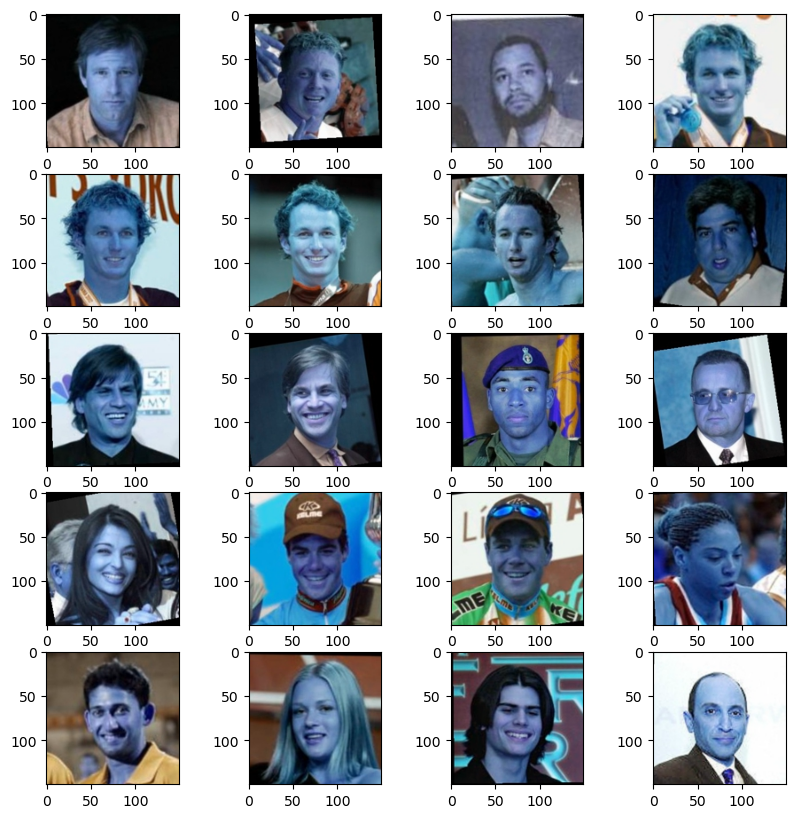

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(len(list_img)):
    plt.subplot(5,4,i+1)
    plt.imshow(list_img[i])

In [5]:
images_dataset = list_img
labels_dataset = img

# Data preprocessing 

In [ ]:
for i in list_img :
    res = cv2.resize(i,dsize=(150, 150), interpolation=cv2.INTER_CUBIC)
    list_img.append(res)

## Create model 

In [6]:
def create_model():
    inputs = Input((150,150,3))
    x = Conv2D(96, (11, 11), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, (5, 5), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(384, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    pooledOutput = tensorflow.keras.layers.GlobalAveragePooling2D()(x)
    pooledOutput = Dense(1024)(pooledOutput)
    outputs = Dense(128)(pooledOutput)

    model = Model(inputs, outputs)
    return model

# Create pairs of images

In [7]:
feature_extractor = create_model()
imgA = Input(shape=(150, 150, 3))
imgB = Input(shape=(150, 150, 3))
featA = feature_extractor(imgA)
featB = feature_extractor(imgB)

# calculate distance for the model 

In [8]:
def euclidean_distance(vectors):
    (featA, featB) = vectors
    sum_squared = k.sum(k.square(featA - featB), axis=1, keepdims=True)
    return k.sqrt(k.maximum(sum_squared, k.epsilon()))

distance = Lambda(euclidean_distance)([featA, featB])
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)

In [9]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [10]:
def generate_train_image_pairs(images_dataset, labels_dataset):
    unique_labels = np.unique(labels_dataset)
    label_wise_indices = dict()
    for label in unique_labels:
        label_wise_indices.setdefault(label,
                                      [index for index, curr_label in enumerate(labels_dataset) if
                                       label == curr_label])
    
    pair_images = []
    pair_labels = []
    for index, image in enumerate(images_dataset):
        pos_indices = label_wise_indices.get(labels_dataset[index])
        pos_image = images_dataset[np.random.choice(pos_indices)]
        pair_images.append((image, pos_image))
        pair_labels.append(1)

        neg_indices = np.where(labels_dataset != labels_dataset[index])
        neg_image = images_dataset[np.random.choice(neg_indices[0])]
        pair_images.append((image, neg_image))
        pair_labels.append(0)
    return np.array(pair_images), np.array(pair_labels)

## Model Training

In [11]:
images_pair, labels_pair = generate_train_image_pairs(images_dataset, labels_dataset)
history = model.fit([images_pair[:, 0],images_pair[:, 1]],labels_pair[:],validation_split=0.1,batch_size=64,epochs=10)

Epoch 1/10
4/4 [==============================] - 155s 37s/step - loss: 49.8194 - accuracy: 0.5000 - val_loss: 1.4014 - val_accuracy: 0.0000e+00
Epoch 2/10
4/4 [==============================] - 159s 37s/step - loss: 1.4644 - accuracy: 0.5000 - val_loss: 0.8263 - val_accuracy: 0.0000e+00
Epoch 3/10
4/4 [==============================] - 159s 36s/step - loss: 0.8854 - accuracy: 0.5000 - val_loss: 0.7216 - val_accuracy: 0.0000e+00
Epoch 4/10
4/4 [==============================] - 160s 37s/step - loss: 0.7271 - accuracy: 0.4899 - val_loss: 0.6999 - val_accuracy: 0.0000e+00
Epoch 5/10
4/4 [==============================] - 159s 36s/step - loss: 0.6988 - accuracy: 0.4444 - val_loss: 0.7004 - val_accuracy: 0.2273
Epoch 6/10
4/4 [==============================] - 161s 37s/step - loss: 0.6963 - accuracy: 0.4848 - val_loss: 0.7007 - val_accuracy: 0.2273
Epoch 7/10
4/4 [==============================] - 159s 36s/step - loss: 0.6958 - accuracy: 0.4949 - val_loss: 0.6993 - val_accuracy: 0.2727
Epo

In [12]:
def generate_test_image_pairs(images_dataset, labels_dataset, image):
    unique_labels = np.unique(labels_dataset)
    label_wise_indices = dict()
    for label in unique_labels:
            label_wise_indices.setdefault(label,
                                        [index for index, curr_label in enumerate(labels_dataset) if
                                         label == curr_label])
    pair_images = []
    pair_labels = []
    for label, indices_for_label in label_wise_indices.items():
        test_image = images_dataset[np.random.choice(indices_for_label)]
        pair_images.append((image, test_image))
        pair_labels.append(label)
    return np.array(pair_images), np.array(pair_labels)

# Testing

1/1 [==============================] - 0s 312ms/step


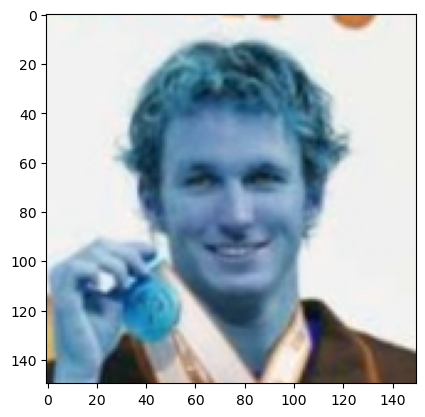

In [18]:
image = images_dataset[3] # a random image as test image
test_image_pairs, test_label_pairs = generate_test_image_pairs(images_dataset, labels_dataset, image) # produce an array of test image pairs and test label pairs
# for each pair in the test image pair, predict the similarity between the images
for index, pair in enumerate(test_image_pairs):
    pair_image1 = np.expand_dims(pair[0], axis=-1)
    pair_image1 = np.expand_dims(pair_image1, axis=0)
    pair_image2 = np.expand_dims(pair[1], axis=-1)
    pair_image2 = np.expand_dims(pair_image2, axis=0)
    prediction = model.predict([pair_image1, pair_image2])[0][0]
    
plt.imshow(image)